# Bitbubble

Simplified ABM model that links the **"How to grow a bubble: A model of myopic adapting agents"** with the **"Leader–follower model for agent based simulation of social collective behavior during egress"** in the bitcoin bubble model space

In [167]:
import random
import numpy as np
import pandas as pd
import datetime as dt
import networkx as nx
import matplotlib as mpl
from mesa import Agent, Model
import matplotlib.pyplot as plt
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
%matplotlib inline
#print(mpl.style.available)
mpl.style.use('ggplot')
#plt.xkcd()
np.random.seed(seed=42)

In [75]:
class MarketMaker(Model):
    """A model with some number of investors."""
    def __init__(self, N, market_depth, alpha=0.95, out_degree=4, C1=1, C2=1, C3=1, seed=None):
        super().__init__(seed)
        self.schedule = RandomActivation(self)
        self.N = N
        self.market_depth = market_depth
        self.alpha = alpha
        self.t = 0
        self.C1 = C1
        self.C2 = C2
        self.C3 = C3
        self.current_price = 1
        self.list_price = [self.current_price]
        self.list_return = [1]
        self.list_sp_return = [1]
        self.list_sigma_return = [1]
        self.list_news = []
        self.list_u = [0]
        self.current_orders = []
        self.G = self.create_network(out_degree, seed)
        self.create_metrics()
        self.news = np.random.normal()
        self.list_news = [self.news]
        
    def create_agents(self): 
        # Create agents
        for i in self.G.nodes():
            a = Investor(i, self, C1=self.C1, C2=self.C2, C3=self.C3)
            self.G.add_node(i)
            self.schedule.add(a)
        
    def create_metrics(self):
        self.datacollector = DataCollector(
            model_reporters = {"price": "current_price"
                            , "r": "r"
                            , "sigma_r": "sigma_r"
                            , "u": "u"
                            , "n": "news"},   
            agent_reporters = {"k": "neighbors_trust",
                              "optin":"optin"})
            
    def step(self):
        '''Advance the model by one step.'''
        self.t = self.t + 1
        self.current_orders = list([])
        "Agents: move!"
        self.schedule.step()
        "After the orders, recalc the price of the asset"
        self.r = self.get_return()
        self.list_return.append(self.r)
        self.current_price = self.calc_price(self.r)
        self.list_price.append(self.current_price)
        self.list_sp_return.append(self.get_special_r(self.t))
        self.sigma_r = self.get_sigma_r(self.t)
        self.list_sigma_return.append(self.sigma_r)
        "Update wealth of agents with the new price"
        for a in self.schedule.agents:
            a.update_wealth(self.current_price)
        """TODO add end conditions (basic, upper limit, lower limit)"""
        if len([i for i, e in enumerate(self.current_orders) if e != 0]) > 0:
            #print("orders for t", self.t, self.r)
            pass
        self.datacollector.collect(self)
        
    def create_network(self, num_edges, seed):
        '''Creates a Barabasi-Albert network with the number of agents and edges.'''
        return nx.generators.random_graphs.barabasi_albert_graph(self.N, num_edges, seed=seed)
    
    def newspaper(self, t):
        available_news = len(self.list_news)
        if available_news <= t:
            for i in range(0, t - (available_news - 1)):
                self.news = np.random.normal()
                self.list_news.append(self.news)
        return self.list_news[t]
    
    def get_price(self, t):
        price = self.list_price[0]
        if t > 0 and t < len(self.list_price):
            price = self.list_price[t]
        return price
    
    def add_order(self, unique_id, s=0, v=0.0):
        self.current_orders.append(s*v)
        
    def get_return(self):
        total = sum(self.current_orders)
        return total / (self.market_depth * self.N)
    
    def calc_price(self, r):
        price = np.exp(np.log(self.current_price) + r)
        return price
    
    def get_special_r(self, t):
        sp_r = self.list_sp_return[0]
        if t > 0 and t <= len(self.list_sp_return):
            sp_r = self.alpha * self.list_sp_return[t-1] + (1-self.alpha) * self.list_return[t-1]
        return sp_r
    
    def get_sigma_r(self, t):
        sigma_r = self.list_sigma_return[0]
        if t > 0 and t <= len(self.list_sigma_return):
            sigma_r = np.sqrt(
                self.alpha * np.square(self.list_sigma_return[t-1])
                + (1-self.alpha) * np.square(self.list_return[t-1] - self.list_sp_return[t-1])
            )
        return sigma_r
    
    def get_news_factor(self, t):
        self.u = self.list_u[0]
        if len(self.list_u) > t:
            self.u = self.list_u[t]
        elif t <= len(self.list_u):
            prev_u = self.list_u[t - 1]
            self.u = (self.alpha * prev_u) + ((1 - self.alpha) * self.newspaper(t - 1))
            self.list_u.append(self.u)
            
        return self.u

In [49]:
class Investor(Agent):
    """An investor with fixed initial cash and coins."""
    def __init__(self, unique_id, model, C1=1, C2=1, C3=1
                 , Omega=2, g=0.02, cash=1.0, coins=1.0):
        super().__init__(unique_id, model)
        self.cash = cash
        self.coins = coins
        self.Omega = Omega
        self.g = g
        #TODO: how to generate closed interval random numbers?
        self.C1 = C1
        self.C1 = C2
        self.C1 = C3
        self.c1 = np.random.uniform(0.0, C1)
        self.c2 = np.random.uniform(0.0, C2)
        self.c3 = np.random.uniform(0.0, C3)
        self.optin = True
        self.w_min = np.random.uniform(0.0, Omega)
        
        self.current_action = 0
        self.current_volume = 0
        self.list_opinions = [0]
        self.list_actions = [0]
        self.list_volumes = [0]
        self.list_cash = [self.cash]
        self.list_coins = [self.coins]
        self.dict_k = self.init_neighbors_k()
        self.private_info = [self.collect_private_info()]
        
    def step(self):
        time = self.model.t
        self.E = self.collect_private_info()
        self.private_info.append(self.E)
        self.opinion = self.get_market_opinion(self.E)
        self.list_opinions.append(self.opinion)
        self.current_action, self.current_volume = self.get_actions(self.opinion, time)
        self.list_actions.append(self.current_action)
        self.list_volumes.append(self.current_volume)
        self.model.add_order(self.unique_id, self.current_action, self.current_volume)
        
    def collect_private_info(self):
        return np.random.normal()
    
    def get_market_opinion(self, E):
        t = self.model.t
        self.neighbors_trust = sum( self.calc_neighbors_trust(t) )
        network_effect = (self.c1) * self.neighbors_trust
        news_effect = (self.c2 * self.model.get_news_factor(t-1) * self.model.newspaper(t))
        idiosyncratic = (self.c3 * E)
        opinion = network_effect + news_effect + idiosyncratic
        
        return opinion
    
    def calc_neighbors_trust(self, t):
        res = []
        for neighbor in self.get_neighbors():
            k_factor = self.get_neighbor_factor(neighbor, t-1)
            n_action = self.get_neighbor_action(neighbor, t)
            res.append(k_factor * n_action)
        return res
        
    def get_neighbors(self):
        return [t[1] for t in self.model.G.edges(self.unique_id)]
    
    def init_neighbors_k(self):
        res = {}
        for n in self.get_neighbors():
            res[n] = [0]
            
        return res
        
    def get_neighbor_factor(self, neighbor_id, time):
        alpha = self.model.alpha
        k = self.dict_k[neighbor_id][0]
        prev_k_list = self.dict_k[neighbor_id]
        prev_k = prev_k_list[0]
        prev_n_action = self.get_neighbor_action(neighbor_id, 0)
        r = self.model.list_return[time]
        sigma_r = self.model.list_sigma_return[time]
        if time > 0 and time <= len(self.dict_k[neighbor_id]):
            prev_k = prev_k_list[time - 1]
            prev_n_action = self.get_neighbor_action(neighbor_id, time - 1)
            first_term = (alpha * prev_k)
            second_term = ((1-alpha) * prev_n_action * r/sigma_r)
            k = first_term + second_term
            prev_k_list.append(k)
            if r != 0 and sigma_r>0 and prev_n_action !=0:
                #print(self.unique_id, time, neighbor_id, "prev_n_action", prev_n_action, "k", k
                #     , "ft", first_term, "r/sigma", r/sigma_r)
                pass

        return k
    
    def get_neighbor_action(self, neighbor_id, time):
        nb_action = random.choice([-1,0,1])
        for a in self.model.schedule.agents:
            if a.unique_id == neighbor_id:
                if time > 0 and time < len(a.list_actions):
                    nb_action = a.list_actions[time-1]
                    
        return nb_action
    
    def get_actions(self, opinion, time):
        s = 0
        v = 0
        if opinion >= self.w_min:
            s = 1
            v = self.g * self.cash / self.model.get_price(time-1)
        elif opinion <= self.w_min * (-1):
            s = -1
            v = self.g * self.coins
        return s, v
        
    def update_wealth(self, price):
        self.cash = self.cash - self.current_action * self.current_volume * price
        self.list_cash.append(self.cash)
        self.coins = self.coins + self.current_action * self.current_volume
        self.list_coins.append(self.coins)
        

## Paper test results
Attempt to replicate the basic (Fig. 1) results with our implementation

In [64]:
def test_env(bitmarket, max_steps):
    bitmarket.create_agents()
    for i in range(max_steps):
        bitmarket.step()
    df_model = bitmarket.datacollector.get_model_vars_dataframe()
    df_agents = bitmarket.datacollector.get_agent_vars_dataframe()
    return df_model, df_agents, bitmarket.G

def plot_test(df_model, df_agents, nw, ax):
    ax[0][0].plot(np.log(df_model.price))
    ax[0][0].set(ylabel='log[price(t)]', xlabel='t', title='Price over time')
    ax[0][1].plot(df_model.n, label='News')
    ax[0][1].plot(df_model.r/df_model.sigma_r, label='Return', color='#000000')
    ax[0][1].set(ylabel='return(t)/stdev, ', xlabel='t', title='r(t) and n(t)')
    ax[0][1].legend()
    ax[1][0].plot(df_model.u)
    ax[1][0].set(ylabel='u(t)', xlabel='t', title='News factor')
    ax[1][1].hist(df_model.r, bins=100, log=False)
    ax[1][1].set(title='Histogram of returns')
    df_k = pd.DataFrame(df_agents.k).reset_index()
    mean_k = []
    for n, grp in df_k.groupby('Step'):
        mean_k.append(np.mean(grp.k))
    ax[2][0].plot(mean_k)
    ax[2][0].set(title='Propensity <k ij>(t) to imitate')
    df_agents_final = df_agents.reset_index()
    df_agents_final = df_agents_final.loc[df_agents_final['Step']==max(df_agents_final['Step'])]
    ax[2][1].hist([t[1] for t in nw.degree()])
    ax[2][1].set(title='Network degree distribution')

Text(0.5,0.98,'C1=1, 500 Agents, 2000 steps')

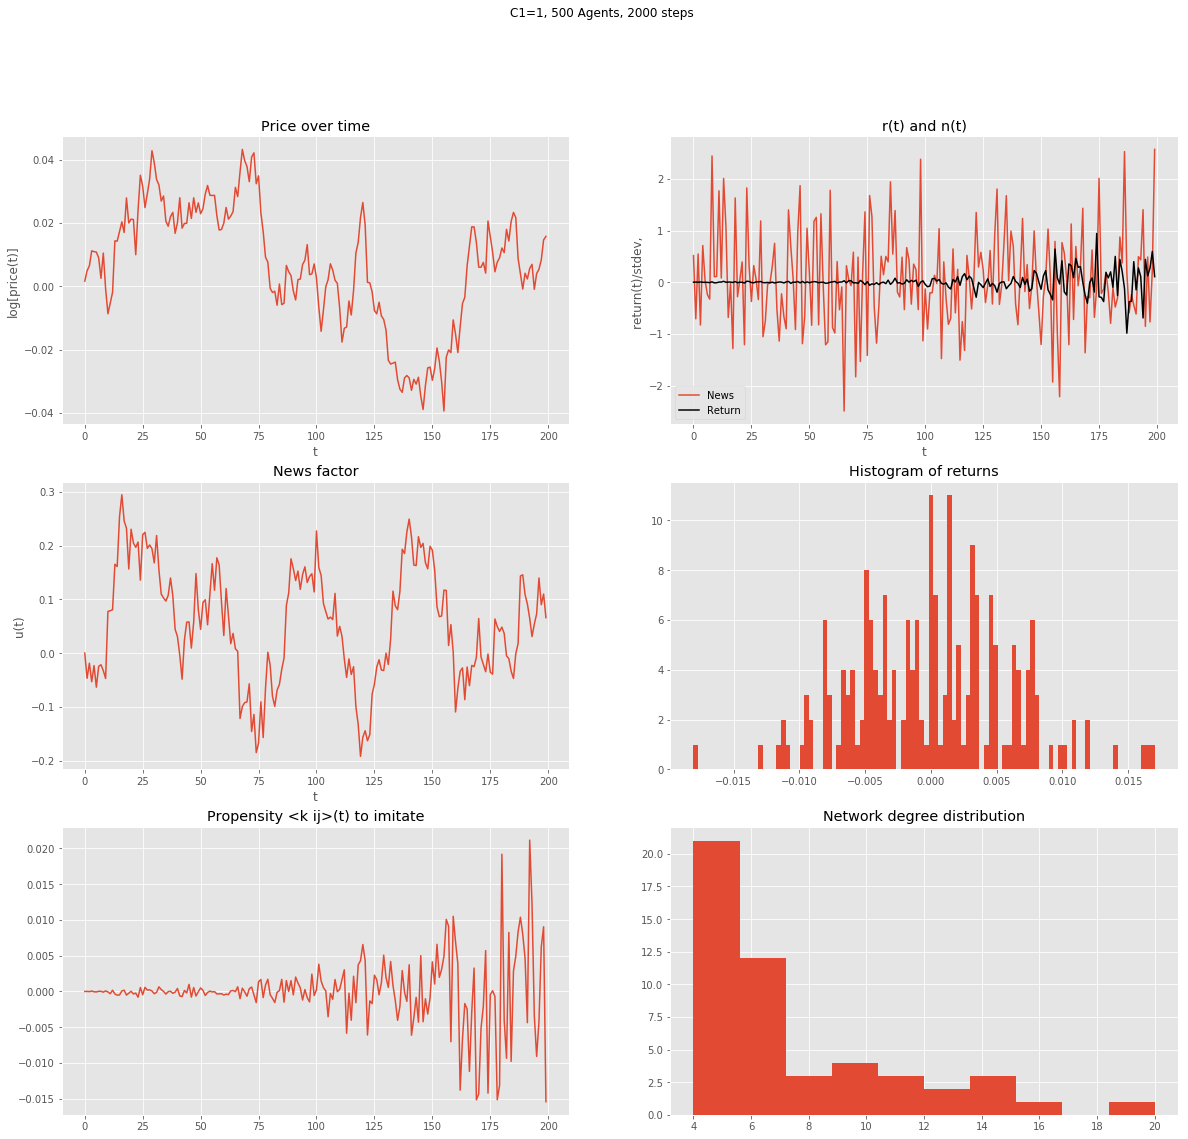

In [69]:
fig, ax = plt.subplots(3,2,figsize=(20,18))
bitmarket = MarketMaker(N=50, market_depth=0.25, seed=42, out_degree=4, C1=1)
df_model, df_agents, nw = test_env(bitmarket, 200)
plot_test(df_model, df_agents, nw, ax)
fig.suptitle('C1=1, 500 Agents, 2000 steps')

## Test with C1=4

Text(0.5,0.98,'C1=4, 500 Agents, 2000 steps')

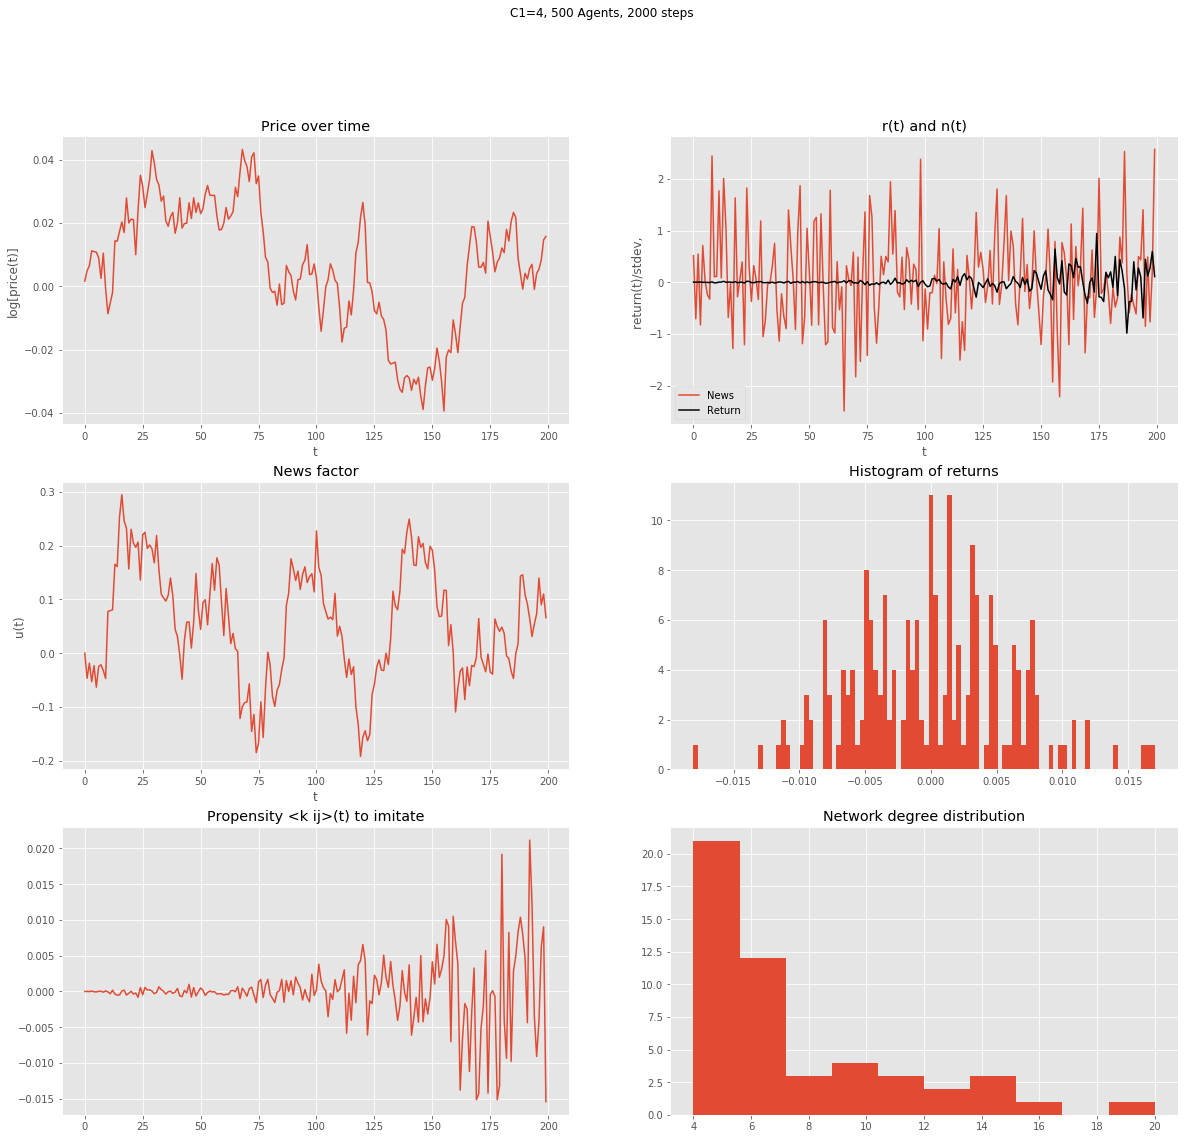

In [70]:
fig, ax = plt.subplots(3,2,figsize=(20,18))
bitmarket_2 = MarketMaker(N=50, market_depth=0.25, seed=42, out_degree=4, C1=4)
df_model_2, df_agents_2, nw_2 = test_env(bitmarket_2, 200)
plot_run(df_model, df_agents, nw_2, ax)
fig.suptitle('C1=4, 500 Agents, 2000 steps')

# Adding the Leader-Follower behavior

## Market Maker changes
- Directed preferential attachment network
- Added global max of risk aversion

In [182]:
class MarketMakerLF(MarketMaker):
    """A model with some number of investors with preferential attachment."""
    def __init__(self, N, market_depth, alpha=0.95, out_degree=4, C1=1, C2=1, C3=1, seed=None
                 , pref_attachment=0.5, C4=1, C5=1):
        self.pref_attachment = pref_attachment
        self.C4 = C4
        self.C5 = C5
        super().__init__(N, market_depth, alpha=alpha, out_degree=out_degree, C1=C1, C2=C2
                         , C3=C3, seed=seed)
        
        
    def create_metrics(self):
        self.datacollector = DataCollector(
            model_reporters = {"price": "current_price"
                            , "r": "r"
                            , "sigma_r": "sigma_r"
                            , "u": "u"
                            , "n": "news"},   
            agent_reporters = {
                              "c1":"c1"
                              , "c2":"c2"
                              , "c3":"c3"
                              , "k": "neighbors_trust"
                              , "optin":"optin"
                              , "risk_aversion":"risk_aversion"
                              , "acceptable_loss":"acceptable_loss"
                              , "learning_rate":"learning_rate"})
        
    def create_agents(self):
        "Create agents that could participate"
        for i in self.G.nodes():
            a = InvestorLF(i, self, C1=self.C1, C2=self.C2, C3=self.C3, C4=self.C4, C5=self.C5)
            self.G.add_node(i)
            self.schedule.add(a)
            
    def create_network(self, num_edges, seed):
        '''Creates a Scale free network with the number of agents and edges.'''
        return nx.generators.random_k_out_graph(self.N, num_edges, self.pref_attachment
                                                , self_loops=False, seed=seed)
    

## Investor Changes
- Optin based on news and network effects and risk aversion
- Optout based on loss and risk aversion

In [154]:
class InvestorLF(Investor):
    """An investor that can opt-in into te market."""
    def __init__(self, unique_id, model, C1=1, C2=1, C3=1, C4=0.1, C5=0.01
                 , Omega=2, g=0.02, cash=1.0, coins=1.0, optin=False
                ):
        super().__init__(unique_id, model, C1=C1, C2=C2, C3=C3
                 , Omega=Omega, g=g, cash=cash, coins=coins)
        self.optin = optin
        self.C1 = C1
        self.C2 = C2
        self.C3 = C3
        self.acceptable_loss = np.random.uniform(0, C4)
        self.learning_rate = np.random.uniform(0, C5)
        self.risk_aversion = np.random.uniform()
    
    def get_market_opinion(self, E):
        opinion = 0
        t = self.model.t
        self.neighbors_trust = sum( self.calc_neighbors_trust(t) )
        if self.optin == True:
            self.optin = self.choose_to_exit(t)
        else:
            self.optin = self.choose_to_enter(t)
            
        if self.optin == True:
            network_effect = (self.c1) * self.neighbors_trust
            news_effect = (self.c2 * self.model.get_news_factor(t-1) * self.model.newspaper(t))
            idiosyncratic = (self.c3 * E)
            opinion = network_effect + news_effect + idiosyncratic
        
        return opinion
    
    def get_neighbors(self):
        return [t[1] for t in self.model.G.out_edges(self.unique_id)]

    def choose_to_exit(self, t):
        stay = True
        last_val = self.model.get_price(t-1) 
        base_val = self.model.get_price(t-2)
        change = (last_val - base_val) / last_val
        if change < -(self.risk_aversion * self.acceptable_loss):
            self.risk_aversion = self.risk_aversion + (self.risk_aversion * self.learning_rate)
            stay = False 
        return stay
    
    def choose_to_enter(self, t):
        prob_adoption = self.get_prob_adoption(t)
        res = np.random.uniform() <= prob_adoption
            
        return res
    
    def get_prob_adoption(self, t):
        '''P = 1 - (1 - news effect)*(1 - network effect)^num followed that already adopted'''
        neighbors = self.get_neighbors()
        influencers = sum([1 for a in self.model.schedule.agents if a.unique_id in neighbors and a.optin == True])
        news_influence = 1 - (self.c2 / self.C2) * self.model.get_news_factor(t-1)
        network_influence = 1 - (self.c1 / self.C1) 
        if self.neighbors_trust > 0:
            network_influence = network_influence * self.neighbors_trust
        P = 1 - (news_influence * (network_influence**influencers))
        # Risk aversion
        P = P - self.risk_aversion
        if P < 0:
            P = 0
            
        return P

In [62]:
def plot_lf(df_model, df_agents, nw, ax):
    ax[0][0].plot(np.log(df_model.price))
    ax[0][0].set(ylabel='log[price(t)]', xlabel='t', title='Price over time')
    ax[0][1].plot(df_model.n, label='News')
    ax[0][1].plot(df_model.r/df_model.sigma_r, label='Return', color='#000000')
    ax[0][1].set(ylabel='return(t)/stdev, ', xlabel='t', title='r(t) and n(t)')
    ax[0][1].legend()
    ax[1][0].plot(df_model.u)
    ax[1][0].set(ylabel='u(t)', xlabel='t', title='News factor')
    ax[1][1].hist(df_model.r, bins=100, log=False)
    ax[1][1].set(title='Histogram of returns')
    df_k = pd.DataFrame(df_agents.k).reset_index()
    mean_k = []
    for n, grp in df_k.groupby('Step'):
        mean_k.append(np.mean(grp.k))
    ax[2][0].plot(mean_k)
    ax[2][0].set(title='Propensity <k ij>(t) to imitate')
    df_agents = df_agents.reset_index()
    num_agents = len(df_agents.AgentID.unique())
    opted_in = df_agents.loc[df_agents.optin==True].groupby('Step').optin.count()
    ax[2][1].plot(100*opted_in/num_agents)
    ax[2][1].set(title='% of adoption', ylabel='% of pop', xlabel='time')

Creating (digraph) preferential nw
Create agents that could participate


Text(0.5,0.98,'C1=4, 500 Agents, 2000 steps')

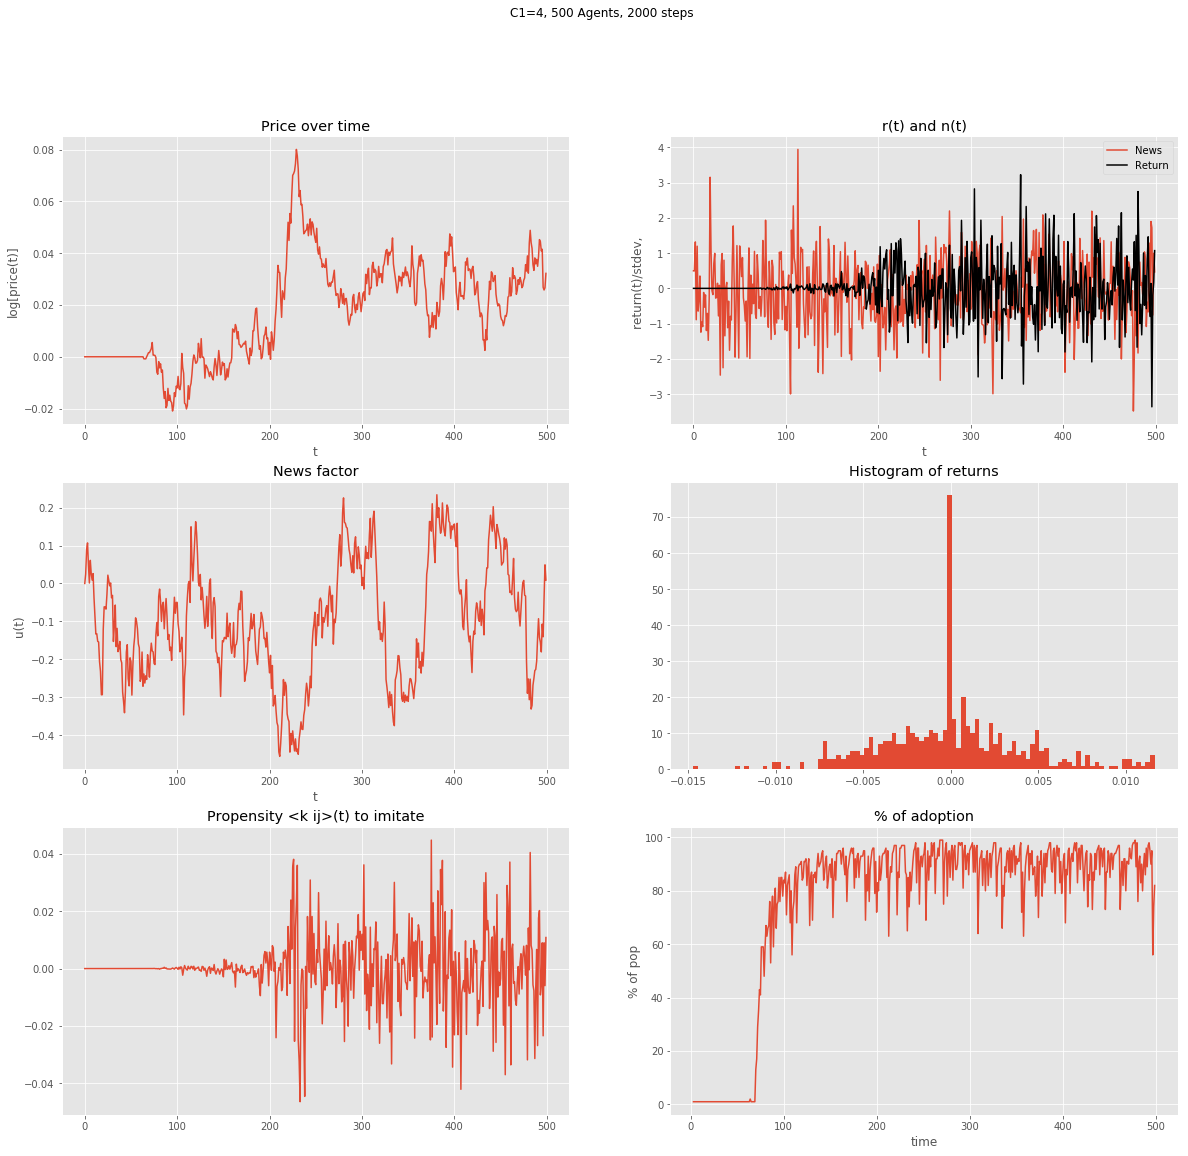

In [156]:
fig, ax = plt.subplots(3,2,figsize=(20,18))
bitmarket_3 = MarketMakerLF(N=100, market_depth=0.25, seed=42, out_degree=4, C1=4)
df_model_3, df_agents_3, nw_3 = test_env(bitmarket_3, 500)
plot_lf(df_model_3, df_agents_3, nw_3, ax)
fig.suptitle('C1=4, 500 Agents, 2000 steps')

# Behavior space

In [219]:
df_models_total = pd.DataFrame([])
df_agents_total = pd.DataFrame([])
df_nodes_total = pd.DataFrame([])
df_edges_total = pd.DataFrame([])
C4_range = np.linspace(0, 0.5, 5)
C5_range = np.linspace(0, 0.2, 5)
out_degree_range = np.arange(4, 10, 1)
N = 50
steps = 50
total_runs = len(C4_range) * len(C5_range) * len(out_degree_range)
current_run = 0
for c4 in C4_range:
    for c5 in C5_range:
        for od in out_degree_range:
            if current_run % 10 == 0:
                print("Run", current_run, " of ", total_runs, "start at:", dt.datetime.now())
            bm = MarketMakerLF(N=N, market_depth=0.25, out_degree=od, C1=4, C4=c4, C5=c5)
            df_m, df_a, nw = test_env(bm, steps)
            df_m['experiment'] = current_run
            df_a['experiment'] = current_run
            df_models_total = df_models_total.append( df_m )
            df_agents_total = df_agents_total.append( df_a.reset_index() )
            df_nodes_total = df_nodes_total.append( pd.DataFrame([{'experiment':current_run
                                                             ,'C4':c4, 'C5':c5, 'max_od':od
                                                             , 'AgentID':t[0], 'in_degree':t[1]} 
                                                            for t in nw.in_degree()]) )
            df_edges = nx.to_pandas_edgelist(nw)
            df_edges['experiment'] = current_run
            df_edges_total = df_edges_total.append( df_edges )
            current_run += 1
            

Run 0  of  150 start at: 2018-05-31 18:51:03.658931
Run 10  of  150 start at: 2018-05-31 18:51:08.020585
Run 20  of  150 start at: 2018-05-31 18:51:12.266229
Run 30  of  150 start at: 2018-05-31 18:51:16.651507
Run 40  of  150 start at: 2018-05-31 18:51:20.644477
Run 50  of  150 start at: 2018-05-31 18:51:24.839814
Run 60  of  150 start at: 2018-05-31 18:51:30.159198
Run 70  of  150 start at: 2018-05-31 18:51:34.335683
Run 80  of  150 start at: 2018-05-31 18:51:38.645134
Run 90  of  150 start at: 2018-05-31 18:51:43.168659
Run 100  of  150 start at: 2018-05-31 18:51:47.253290
Run 110  of  150 start at: 2018-05-31 18:51:51.689409
Run 120  of  150 start at: 2018-05-31 18:51:56.214035
Run 130  of  150 start at: 2018-05-31 18:52:00.616260
Run 140  of  150 start at: 2018-05-31 18:52:06.026903


In [220]:
df_models_total.to_csv('./data/df_models_total.csv', index=False)
df_agents_total.to_csv('./data/df_agents_total.csv', index=False)
df_nodes_total.to_csv('./data/df_nodes_total.csv', index=False)
df_edges_total.to_csv('./data/df_edges_total.csv', index=False)

## TODO: Analysis of results
- Identify hubs (nodes with in_degree higher than E(in_degre)+xtimes\*Stdv(in_degre)
- Identify time to adoption of hubs
- Classify leaders / followers
- Identify correlation with c1,c2,c3,c4,c5
- Identify optout behaviour